# How does health insurance affect rates of use and abuse of opioids?
### Data Science - 2019
### Filipe Borba & Micah Reid

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from thinkstats2 import Pmf, Cdf
import thinkplot
width = 0.4 #Width of the histograms, optional

"The National Survey on Drug Use and Health (NSDUH) provides up-to-date information on tobacco, alcohol, and drug use, mental health and other health-related issues in the United States.

NSDUH began in 1971 and is conducted every year in all 50 states and the District of Columbia. This year almost 70,000 people will be interviewed for this important study.

Information from NSDUH is used to support prevention and treatment programs, monitor substance use trends, estimate the need for treatment and inform public health policy."

The data loaded here is the result of a cleaned version of the NSDUH 2018 dataset. Only the important variables were separated and treated so the analysis would be less confusing. If you want to know more about that, access the "Data Management" notebook!

We are very interested in the opioid crisis in the United States, so we wanted to investigate how the health insurance system is related to this problem. We have a more exploratory approach to the dataset and cenario, but we explain every passage so the reader knows what is happening.

In [2]:
df = pd.read_pickle('cleaned_nsduh.pkl')
df.head(2)

,SEX,AGE,PRES_PAINKILLER_USE,REC_PAINKILLER_MISUSE,ANY_PAINKILLER_LIFETIME,OXYCONTIN_USE,OXYCONTIN_MISUSED,INCOME,FAMILY_INCOME,EDUCATION,CAIDCHIP_HI,PRIVATE_HI,ANY_HI,HEALTH_INSURANCE
0,Male,65+,Never used,Never misused,Not used,Not used in past year,Did not misuse - past year,75k+,75k+,College Graduate,Doesn't have Medicaid/CHIP,Has Private HI,With HI,Has Private HI
1,Male,35-49,Used in 12+ months,Never misused,Used,Not used in past year,Did not misuse - past year,30-40k,30-40k,College Graduate,Has Medicaid/CHIP,Doesn't have Private HI,With HI,Has Medicaid/CHIP


## Variables
#### Demographics
irsex = SEX = Respondent's sex | ("Male","Female")  
AGE2 = AGE = Respondent's age | ("12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22-23", "24-25", "26-29", "30-34", "35-49", "50-64", "65+")  
IRPINC3 = INCOME = Respondent's total income | ("10k or less", "10-20k", "20-30k", "30-40k", "40-50k", "50-75k", "75k+")  
IRFAMIN3 = FAMILY_INCOME = Respondent's family total income | ("10k or less", "10-20k", "20-30k", "30-40k", "40-50k", "50-75k", "75k+")  
eduhighcat = EDUCATION = Respondent's education category | ("Less High School", "High School Grad", "Some Coll/Assoc Degree", "College Graduate", "12-17 year olds")  

#### Health Insurance
irmcdchp = CAIDCHIP_HI = If respondent has or not the CAIDCHIP Health Insurance | ("Has Medicaid/CHIP", "Doesn't have Medicaid/CHIP")  
irprvhlt = PRIVATE_HI = If respondent has or not any Private Health Insurance | ("Has Private HI", "Doesn't have Private HI")  
IRINSUR4 = ANY_HI = If respondent has or not any kind of Health Insurance | ("With HI", "Without HI")  

#### Pain Killer usage
iroxcnanyyr = OXYCONTIN_USE =  Any OxyContin use recency | ("Used in past year", "Not used in past year")  
iroxcnnmyr = OXYCONTIN_MISUSED = OxyContin past year misuse | ("Misused - past year", "Did not misuse - past year")  
pnranylif = ANY_PAINKILLER_LIFETIME = Any pain reliever used in lifetime | ("Used", "Not used", "Used (assumed)", "Don't Know", "Refused", "Blank")  
irpnranyrec = PRES_PAINKILLER_USE = Any use of pain reliever | ("Used within year", "Used in 12+ months", "Never used")  
irpnrnmrec = REC_PAINKILLER_MISUSE = Pain reliever misuse recency | ("Misused in last 30 days", "Misused 31 days-12 months", "Misused 12+ months", "Never misused")   

## Demographic Information
The first thing we'll analyse is the characteristic of the average respondents in the dataset. We need to see how well the population is distributed and check for oversampling features. For that, we'll use common variables (age, sex, education, etc.) to look more into it.

3.912858056720453


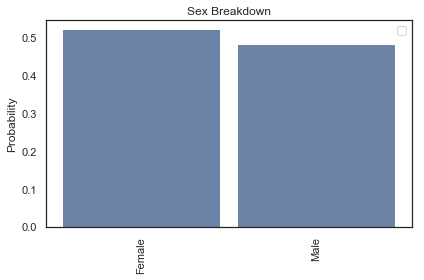

In [3]:
pmf_a = Pmf(df["SEX"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 2, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Sex Breakdown')
print((pmf_a["Female"] - pmf_a["Male"])*100)

As we can see from the sex PMF, the dataset has slightly more female respondents than male. The difference is 3.91%.

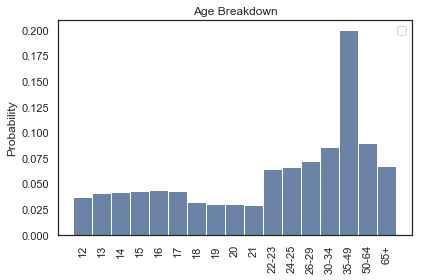

In [4]:
pmf_a = Pmf(df["AGE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 17, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Age Breakdown')

In [5]:
print("12-17: ", (pmf_a["12"]+pmf_a["13"]+pmf_a["14"]+pmf_a["15"]+pmf_a["16"]+pmf_a["17"])*100)
print("18-21: ", (pmf_a["18"]+pmf_a["19"]+pmf_a["20"]+pmf_a["21"])*100)
print("22-23: ", (pmf_a["22-23"])*100)
print("24-25: ", (pmf_a["24-25"])*100)
print("26-29: ", (pmf_a["26-29"])*100)
print("30-34: ", (pmf_a["30-34"])*100)
print("35-49: ", (pmf_a["35-49"])*100)
print("50-64: ", (pmf_a["50-64"])*100)
print("65+: ", (pmf_a["65+"])*100)

12-17:  24.38339611912716
18-21:  11.73857417016135
22-23:  6.317080105195822
24-25:  6.537422702395338
26-29:  7.088279195394128
30-34:  8.524059990049045
35-49:  19.926789395124032
50-64:  8.879451275854716
65+:  6.604947046698416


This is a tricky PMF, because we have different ranges of ages for every category, so we need to be extra careful while analysing.
First, we can see that through ages 12 to 21, we have only one category for each age, while the others are more in a "range" organization. By summing the probabilities of ages 12-17 (underaged) we can see that they represent a huge part of the dataset. If we consider the 12-21 year old range, they represent 36% of the respondents in the dataset. Relatively, it's a big number, so we have to consider oversampling for young people.

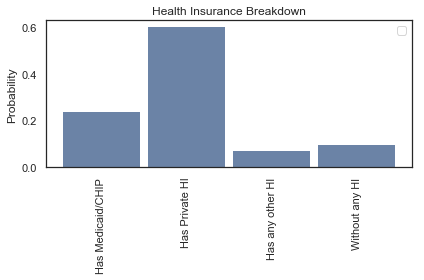

In [6]:
pmf_a = Pmf(df["HEALTH_INSURANCE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 4, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Health Insurance Breakdown')

In [7]:
pmf_a

Pmf({'Has Private HI': 0.5980169166252044, 'Has Medicaid/CHIP': 0.23610420072499824, 'Without any HI': 0.09396545596701969, 'Has any other HI': 0.07191342668277774})

We can clearly see that most people have Private Health Insurance in the dataset too, so we need to be careful with that. Almost 60% of the respondents have a kind of private health insurance.

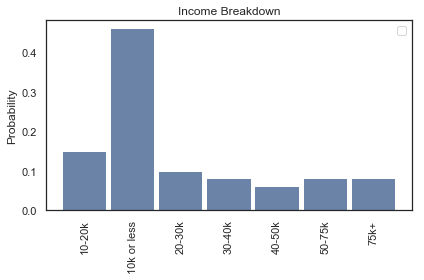

In [8]:
pmf_a = Pmf(df["INCOME"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 7, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Income Breakdown')

Lots of 12-21 year olds, that's one of the reasons why the 10k or less category is has a higher probability in the PMF. In the end, it is not a good variable to rely on, so Family Income can tell us more.

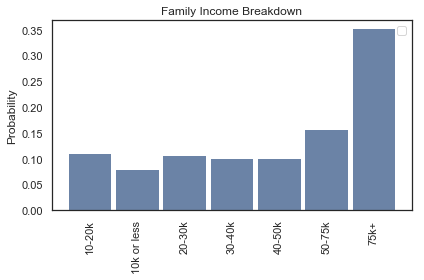

In [9]:
pmf_a = Pmf(df["FAMILY_INCOME"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 7, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Family Income Breakdown')

Family Income has a better approach because it is not as dependant on the respondent's age. As we can see, the 75k+ category is higher, which can one of the reasons to explain why respondents in this dataset are more likely to have a private health insurance.

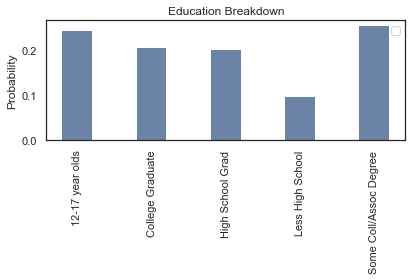

In [10]:
pmf_a = Pmf(df["EDUCATION"])
thinkplot.Hist(pmf_a, width=width)
plt.xticks(np.arange(0, 5, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Education Breakdown')

Looking at the education PMF, we can see that most of the respondents older than 17 years have at least finished High School. Only 10% of the respondents have less than High School education, which makes this group a little less represented in the dataset.

## Comparing two groups
##### No health insurance vs Private health insurance

In [11]:
no_hi = df[df.HEALTH_INSURANCE != "Has Private HI"]
priv_hi = df[df.HEALTH_INSURANCE == "Has Private HI"]

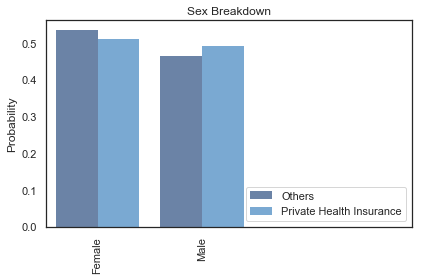

In [12]:
pmf_a = Pmf(no_hi["SEX"], label='Others')
pmf_b = Pmf(priv_hi["SEX"], label='Private Health Insurance')
thinkplot.Hist(pmf_a, align="right", width=width)
thinkplot.Hist(pmf_b, align="left", width=width)
plt.xticks(np.arange(0, 4, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Sex Breakdown', loc='lower right')

Comparing both groups, we can see that there are small differences between the groups, but if the respondent doesn't have a private health insurance, it is slightly more likely to be a female respondent.

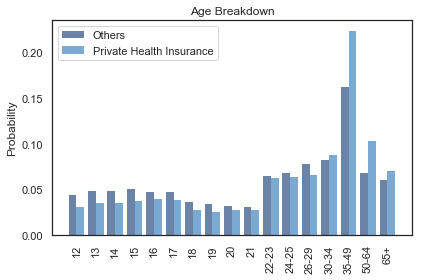

In [13]:
pmf_a = Pmf(no_hi["AGE"], label='Others')
pmf_b = Pmf(priv_hi["AGE"], label='Private Health Insurance')
thinkplot.Hist(pmf_a, align="right", width=width)
thinkplot.Hist(pmf_b, align="left", width=width)
plt.xticks(np.arange(0, 18, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Age Breakdown', loc='upper left')

Looking at the age PMF for both groups, it is pretty visible that there's a significant difference in the 35-49 and 50-64 age range. This may be due to the idea that older people are more likely to be financially successful than young people that are just starting their carreers and don't have apparent health problems.

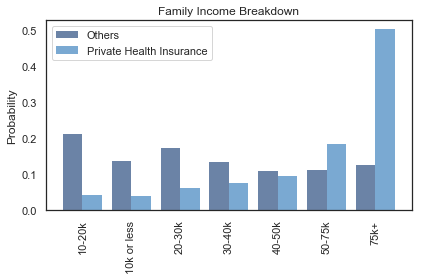

In [14]:
pmf_a = Pmf(no_hi["FAMILY_INCOME"], label='Others')
pmf_b = Pmf(priv_hi["FAMILY_INCOME"], label='Private Health Insurance')
thinkplot.Hist(pmf_a, align="right", width=width)
thinkplot.Hist(pmf_b, align="left", width=width)
plt.xticks(np.arange(0, 7, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Family Income Breakdown', loc='upper left')

Looking at the family income PMFs, there is an obvious difference between groups. People who have a private insurance tend to be much richer than the other group. This will reflect on education, but also probably on how they perceive health problems and how they misuse medicines. Our expectation is that people who have private insurance will be less inclined to misuse medicines.

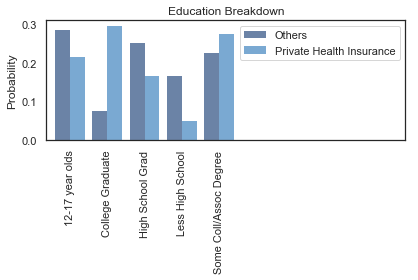

In [15]:
pmf_a = Pmf(no_hi["EDUCATION"], label='Others')
pmf_b = Pmf(priv_hi["EDUCATION"], label='Private Health Insurance')
thinkplot.Hist(pmf_a, align="right", width=width)
thinkplot.Hist(pmf_b, align="left", width=width)
plt.xticks(np.arange(0, 10, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Education Breakdown', loc='upper right')

As expected, people who have private health insurance tend to have a better education than the other group (higher family income, older people and other factors). This tells us that probably people who have a private health insurance are less inclined to misuse medicines and are more conscious about their health.

## Exploring Crosstabs

#### Health Insurance and Painkiller use

In [16]:
ct = pd.crosstab(df["HEALTH_INSURANCE"], df["PRES_PAINKILLER_USE"], 
                 rownames=['Health Insurance'], colnames=['Used Prescription Painkillers'], 
                 margins=True, normalize='index')
(ct*100).round(decimals=3)

Used Prescription Painkillers,Used within year,Used in 12+ months,Never used
Health Insurance,,,
Has Medicaid/CHIP,32.189,12.900,54.911
Has Private HI,29.004,28.656,42.340
Has any other HI,34.198,23.449,42.352
Without any HI,28.177,19.232,52.591
All,46.272,23.676,30.052


As we can see from the crosstable, people who have a private health insurance or others (except Medicaid/CHIP) were more likely to have taken opioids. Also, people who have Medicaid/Chip were more likely to have taken painkillers within the year than people without insurance, but they were less likely to have used in more than a year ago.

In [17]:
ct = pd.crosstab(df["HEALTH_INSURANCE"], df["REC_PAINKILLER_MISUSE"],
                 rownames=['Health Insurance'], colnames=['Misused Prescription Painkillers'],
                  margins=True, normalize='index')
(ct*100).round(decimals=3)

Misused Prescription Painkillers,Misused in last 30 days,Misused 31 days-12 months,Misused 12+ months,Never misused
Health Insurance,,,,
Has Medicaid/CHIP,1.957,4.260,4.892,88.891
Has Private HI,1.037,3.046,6.029,89.888
Has any other HI,1.334,2.891,4.868,90.907
Without any HI,2.402,4.293,6.222,87.084
All,89.463,5.695,3.438,1.404


Misuse of prescription drugs is defined as use in any way not directed by a doctor, including use without a prescription of one's own medication; use in greater amounts, more often, or longer than told to take a drug; or use in any other way not directed by a doctor.  
As we can see from the crosstab, there a few small differences between the misuse of the groups. In general, people without any health insurance are slightly more likely to have misused opioids in some way.

In [18]:
ct = pd.crosstab(df["ANY_HI"], df["PRES_PAINKILLER_USE"], 
                 rownames=['Any Health Insurance'], colnames=['Used Prescription Painkillers'],
                 margins=True, normalize="index")
(ct*100).round(decimals=3)

Used Prescription Painkillers,Used within year,Used in 12+ months,Never used
Any Health Insurance,,,
With HI,30.246,24.137,45.617
Without HI,28.177,19.232,52.591
All,46.272,23.676,30.052


However, by sorting people with and without any health insurance, we can see that having any type of health insurance seems to be related to increased opioid use in the short and long term.

#### Filtering by: Used any painkiller

The idea now is to analyse only people who have used any pain killers in their lifetime. With that, we can see a higher relative difference in the variables.

In [19]:
used_pk = df[df.PRES_PAINKILLER_USE != "Never used"]

In [20]:
ct = pd.crosstab(used_pk["HEALTH_INSURANCE"], used_pk["PRES_PAINKILLER_USE"],
                 rownames=['Health Insurance'], colnames=['Used Prescription Painkillers'],
                 margins=True, normalize='index')
(ct*100).round(decimals=3)

Used Prescription Painkillers,Used within year,Used in 12+ months
Health Insurance,,
Has Medicaid/CHIP,71.390,28.610
Has Private HI,50.301,49.699
Has any other HI,59.323,40.677
Without any HI,59.434,40.566
All,44.067,55.933


Of those who had ever used prescription painkillers, those on Medicaid/CHIP had a significantly higher chance of taking them recently than the other groups. People who have a private health insurance were more likely to have had them in the past.

In [21]:
ct = pd.crosstab(used_pk["HEALTH_INSURANCE"], used_pk["REC_PAINKILLER_MISUSE"],
                 rownames=['Health Insurance'], colnames=['Misused Prescription Painkillers'],
                  margins=True, normalize='index')
(ct*100).round(decimals=3)

Misused Prescription Painkillers,Misused in last 30 days,Misused 31 days-12 months,Misused 12+ months,Never misused
Health Insurance,,,,
Has Medicaid/CHIP,4.340,9.448,10.850,75.363
Has Private HI,1.799,5.282,10.456,82.463
Has any other HI,2.315,5.015,8.444,84.226
Without any HI,5.066,9.055,13.123,72.756
All,80.388,10.600,6.400,2.613


By only selecting people who have taken any pain relievers, the difference between the groups of health insurance become more apparent. People without any health insurance and people with Medicaid/CHIP were more likely to have misused pain relievers.

In [22]:
ct = pd.crosstab(used_pk["ANY_HI"], used_pk["PRES_PAINKILLER_USE"], 
                 rownames=['Any Health Insurance'], colnames=['Used Prescription Painkillers'],
                 margins=True, normalize="index")
(ct*100).round(decimals=3)

Used Prescription Painkillers,Used within year,Used in 12+ months
Any Health Insurance,,
With HI,55.617,44.383
Without HI,59.434,40.566
All,44.067,55.933


Of those who had ever used prescription painkillers, those without any health insurance were more likely to have taken them recently (within a year).

## Explorimg PMFs

Here we want to get a more visual look at the distributions. For that, we plot different PMFs and analyse them.

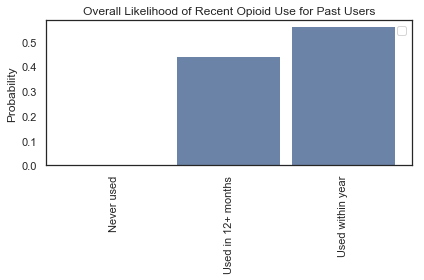

In [23]:
pmf_a = Pmf(used_pk["PRES_PAINKILLER_USE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 3, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Overall Likelihood of Recent Opioid Use for Past Users')

Over half of all people who have ever tried opioids have continued to take them in the past year. Some of this could be because first time use was in the past year, but it is unlikely to be a majority. 

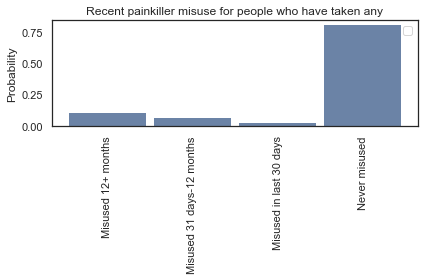

In [24]:
pmf_a = Pmf(used_pk["REC_PAINKILLER_MISUSE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 4, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Recent painkiller misuse for people who have taken any')

The recent painkiller misuse PMF shows us the distribution of misuse for all the respondents. We can see that people are more likely to have misused them within more than a year from the survey. It is more visual than the crosstab.

## Comparing two groups

Here we make a few histograms that compare the two groups: people who have private health insurance and those who have others or not at all. We're interesing in any difference here.

In [25]:
no_hi = df[df.HEALTH_INSURANCE != "Has Private HI"]
priv_hi = df[df.HEALTH_INSURANCE == "Has Private HI"]

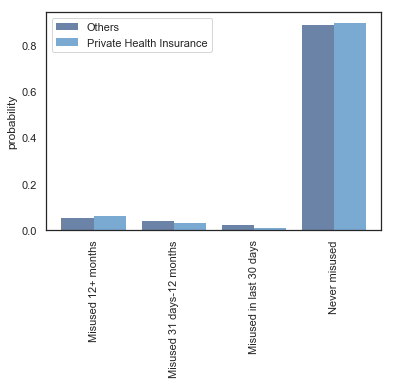

In [26]:
pmf_a = Pmf(no_hi["REC_PAINKILLER_MISUSE"])
pmf_b = Pmf(priv_hi["REC_PAINKILLER_MISUSE"])
thinkplot.Hist(pmf_a, align='right', width=width, label = 'Others')
thinkplot.Hist(pmf_b, align='left', width=width, label = 'Private Health Insurance')
plt.xticks(np.arange(0, 4, step=1), rotation='vertical')
thinkplot.Config(ylabel='probability')

Within the year of the survey, those without health insurance were more likely to have abused painkillers than those with private health insurance. People with the private health insurance were more likely to have abused them in the past (more than a year from the survey).

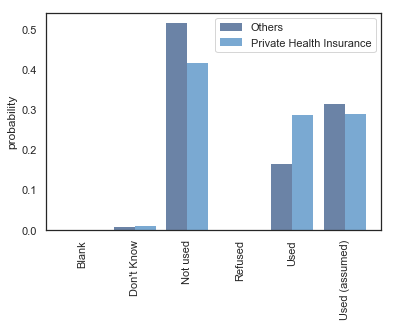

In [27]:
pmf_c = Pmf(no_hi["ANY_PAINKILLER_LIFETIME"])
pmf_d = Pmf(priv_hi["ANY_PAINKILLER_LIFETIME"])
thinkplot.Hist(pmf_c, align='right', width=width, label = 'Others')
thinkplot.Hist(pmf_d, align='left', width=width, label = 'Private Health Insurance')
plt.xticks(np.arange(0, 6, step=1), rotation='vertical')
thinkplot.Config(ylabel='probability')

In this PMF we can see an interesting difference. People with private health insurance were more likely to have had a prescription pain reliever in their lifetime. We can check that in more depth by plotting the PRES_PAINKILLER_USE variable PMF.

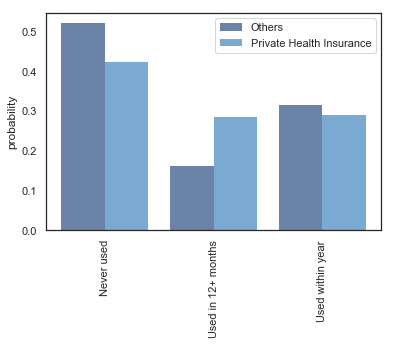

In [28]:
pmf_e = Pmf(no_hi["PRES_PAINKILLER_USE"])
pmf_f = Pmf(priv_hi["PRES_PAINKILLER_USE"])
thinkplot.Hist(pmf_e, align='right', width=width, label = 'Others')
thinkplot.Hist(pmf_f, align='left', width=width, label = 'Private Health Insurance')
plt.xticks(np.arange(0, 3, step=1), rotation='vertical')
thinkplot.Config(ylabel='probability')

In [36]:
print(pmf_e)
print(pmf_f)
diff = (pmf_f["Used in 12+ months"] - pmf_e["Used in 12+ months"])*100
print(round(diff, 2))

Pmf({'Never used': 0.5212182830872601, 'Used within year': 0.31610821324374505, 'Used in 12+ months': 0.16267350366899477})
Pmf({'Never used': 0.4233969216140726, 'Used within year': 0.29003981696083675, 'Used in 12+ months': 0.2865632614250906})
12.39


Here's something really interesting! People that have a private health insurance were 12.39% more likely to have taken any kind of prescription pain reliever in the past year.  
This is not expected! As we saw during the demographic analysis, people who have private health insurance have a better education than the other group, with that, we would expect that they would value their health more and use a less strong medicine. 